# LDA Model on Medical Docket CMS-2021-0168
## By Sambit Sahoo

In [1]:
import pandas as pd
import numpy as np
import re
import time

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models

import spacy
from spacy.tokenizer import Tokenizer
from spacy import displacy
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sambitsahoo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sambitsahoo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Data Collection and Curation:
Using the datasets I was given by Ph.D. student Faizan Wajid, I started by removing columns of information that were irrevelant for the LDA model I will be using later. The important columns that I will be keeping from the 2 dataframes are the comment (string), comment_id (string), attachment_num (int), docket_id (string), and comment_id_att (string). Also, I will add a column called 'label', which denotes whether the text is a comment (0) or attachment (1). Generally, a comment is more opinionated and an attachment is a supporting document, such as an article, research paper, etc. 

In [2]:
df_atts = pd.read_csv("Not_a_comment_records_from_dynamo_db.csv")
df_exp = pd.read_csv("dataset_expanded.csv", index_col=0)
df_atts.head(3)

comment_id.S  attachment_num.N      comment_id_att.S  \
0  CMS-2022-0074-1266                 4  CMS-2022-0074-1266_4   
1  CMS-2022-0074-1240                 3  CMS-2022-0074-1240_3   
2  CMS-2022-0074-1240                 2  CMS-2022-0074-1240_2   

                                           comment.S                user.S  \
0  Barrett et al. Annals of Intensive Care   (202...  harpokta_test.abagyi   
1  Open Forum Infectious Diseases B R I E F R E P...  harpokta_test.abagyi   
2  The Art and Science of Infusion Nursing The Ar...  harpokta_test.abagyi   

     docket_id.S            when.S                       user_docket.S  
0  CMS-2022-0074  2022/10/06 13:57  harpokta_test.abagyi_CMS-2022-0074  
1  CMS-2022-0074  2022/10/06 14:00  harpokta_test.abagyi_CMS-2022-0074  
2  CMS-2022-0074  2022/10/06 14:00  harpokta_test.abagyi_CMS-2022-0074

In [3]:
docket_regex = "CMS-2021-0168"
df_atts.columns = ['comment_id', 'attachment_num', 'comment_id_att', 'comment', 'user', 'docket_id', 'when', 'user_docket']
df_atts = df_atts.drop(columns=['user', 'when', 'user_docket'])
df_atts = df_atts[df_atts['docket_id'].str.match(docket_regex)]
comment = df_atts.pop('comment')
att = df_atts.pop('comment_id_att')
df_atts.insert(0, 'comment', comment)
df_atts.insert(4, 'comment_id_att', att)
df_atts['label'] = df_atts.apply(lambda x: 1, axis=1)
print(df_atts.shape)
df_atts.head()

(36, 6)


comment          comment_id  \
27  11/12/21, 2:29 PM 81 Research Studies Confirm ...  CMS-2021-0168-9421   
28  CDC Manipulated Studies In Order to Prop Up Of...  CMS-2021-0168-9421   
29  European Journal of Epidemiology https://doi.o...  CMS-2021-0168-9421   
30  medRxiv preprint  doi:  https://doi.org/10.110...  CMS-2021-0168-9421   
31  healthcare workers, Vietnam Nguyen Van Vinh Ch...  CMS-2021-0168-9421   

    attachment_num      docket_id        comment_id_att  label  
27               8  CMS-2021-0168  CMS-2021-0168-9421_8      1  
28               7  CMS-2021-0168  CMS-2021-0168-9421_7      1  
29               6  CMS-2021-0168  CMS-2021-0168-9421_6      1  
30               5  CMS-2021-0168  CMS-2021-0168-9421_5      1  
31               4  CMS-2021-0168  CMS-2021-0168-9421_4      1

In [4]:
df_exp['docket_id'] = df_exp.apply(lambda x: "CMS-2021-0168", axis=1)
df_exp['comment_id_att'] = df_exp.apply(lambda x: str(x.comment_id) + "_" + str(x.attachment_num), axis=1)
df_exp['label'] = df_exp['attachment_num'].apply(lambda x: 0 if x == 0 else 1)
print(df_exp.shape)
df_exp.head()

(3496, 6)


comment          comment_id  \
0  Healthcare workers have lost all rights; they ...  CMS-2021-0168-0002   
1  Immunity for having the virus should be consid...  CMS-2021-0168-0003   
2  This emergency vaccine mandate or lose your jo...  CMS-2021-0168-0004   
3  file code CMS-3415-IFC: Does this code apply t...  CMS-2021-0168-0005   
4  I am definitely in favor of a vaccine mandate ...  CMS-2021-0168-0006   

   attachment_num      docket_id        comment_id_att  label  
0               0  CMS-2021-0168  CMS-2021-0168-0002_0      0  
1               0  CMS-2021-0168  CMS-2021-0168-0003_0      0  
2               0  CMS-2021-0168  CMS-2021-0168-0004_0      0  
3               0  CMS-2021-0168  CMS-2021-0168-0005_0      0  
4               0  CMS-2021-0168  CMS-2021-0168-0006_0      0

## Basic EDA and Filtering:
I looked through the dataframe to see how many comments and attachments there were. Since there were 3215 comments and 281 attachments, there was the possibility that the LDA model would overfit with this dataset since there is an overwhelming amount of comments. I decided to only include comments and attachments that exceeded 1500 characters. Now, the dataframe contained 458 comments and 218 attachments.

In [5]:
label0 = 0
labelnot0 = 0
dict_comment_size = {}
for index, row in df_exp.iterrows():
    if len(row['comment']) == 799229:
        print(row['comment'])
    if len(row['comment']) in dict_comment_size:
        dict_comment_size[len(row['comment'])] += 1
    else:
        dict_comment_size[len(row['comment'])] = 1
    if row['label'] == 0:
        label0 += 1
    else:
        labelnot0 += 1
print("Comments: ", label0)
print("Attachments: ", labelnot0)
print(dict_comment_size)
print(len(dict_comment_size))
lst = dict_comment_size.keys()
print(max(lst), min(lst))
lst_sub100 = list()
for x in dict_comment_size.keys():
    if x < 100:
        lst_sub100.append((x, dict_comment_size[x]))
print(lst_sub100)
amt = 0
for (_,y) in lst_sub100:
    amt += y
print(amt)

            The Fauci/COVID-19 Dossier  This document is prepared for humanity by Dr. David E. Martin.            Fauci/COVID-19 Dossier       CC-BY-NC-SA Dr. David E. Martin        1     The Fauci/COVID-19 Dossier  This document is prepared for humanity by Dr. David E. Martin.      This work was supported, in part, by a fund-raising effort in which approximately 330 persons contributed funds in support of the New Earth technology team and Urban Global Health Alliance. It is released under a Creative Commons license CC- BY-NC-SA. Any derivative use of this dossier must be made public for the benefit of others. All documents, references and disclosures contained herein are subject to an AS-IS representation. The author does not bear responsibility for errors in the public record or references therein. Throughout this document, uses of terms commonly accepted in medical and scientific literature do not imply acceptance or rejection of the dogma that they represent.   Background:  Over th

In [6]:
df_exp['len'] = df_exp['comment'].apply(lambda x: len(x))
df_exp = df_exp[df_exp['len'] >= 1500]
label0 = 0
labelnot0 = 0
dict_comment_size = {}
for index, row in df_exp.iterrows():
    if len(row['comment']) in dict_comment_size:
        dict_comment_size[len(row['comment'])] += 1
    else:
        dict_comment_size[len(row['comment'])] = 1
    if row['label'] == 0:
        label0 += 1
    else:
        labelnot0 += 1
print("Comments: ", label0)
print("Attachments: ", labelnot0)

            The Fauci/COVID-19 Dossier  This document is prepared for humanity by Dr. David E. Martin.            Fauci/COVID-19 Dossier       CC-BY-NC-SA Dr. David E. Martin        1     The Fauci/COVID-19 Dossier  This document is prepared for humanity by Dr. David E. Martin.      This work was supported, in part, by a fund-raising effort in which approximately 330 persons contributed funds in support of the New Earth technology team and Urban Global Health Alliance. It is released under a Creative Commons license CC- BY-NC-SA. Any derivative use of this dossier must be made public for the benefit of others. All documents, references and disclosures contained herein are subject to an AS-IS representation. The author does not bear responsibility for errors in the public record or references therein. Throughout this document, uses of terms commonly accepted in medical and scientific literature do not imply acceptance or rejection of the dogma that they represent.   Background:  Over th

In [7]:
df_exp.shape

(672, 7)

## Helper Functions:
Here is a handful of helper function that I used throughout the LDA process:\
lemmatize_stemming(text) --> Given a token, it lemmatizes the word, then uses the stemmer. Using this will slow down the performance, but is beneficial to run.\
preprocess(text) --> Given text, it tokenizes the text then appends it to a returned list if the token has a length greater than 3 and is not a stopword.\
ldaModel(corpus, numTopics, id2word) --> Given a corpus, the number of topics, and dictionary, it returns an LDA model with the specified parameters.\
pyLDAvisViz(lda, corpus, dictionary) --> Given an LDA model, corpus, and dictionary, it returns the pyLDAvis visualization of the LDA model.\
coherence(model, dictionary, text) --> Given an LDA model, dictionary, and text, it returns the topic coherence score of the LDA model.\
dominant_topics(ldamodel, corpus, texts) --> Given an LDA model, corpus, and the texts, it returns a dataframe with the dominant topic, percent contribution of the dominant topic and topic keywords for each text.

In [26]:
nlp = spacy.load("en_core_web_sm")
# Helper Functions
## Stem & Lemmatize
def lemmatize_stemming(text):
    stemmer = PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

## inline function (change LEMSTEM to False if preserving word)
def preprocess(text):
    result = []
    # converts the comment into a list of tokens
    for token in gensim.utils.simple_preprocess(text):
        # if the word is not a stopword and is more than 3 characters
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            # result.append(token)
           
    return result

# given the corpus, dict, and number of topics, it will return a LDA model
def ldaModel(corpus, numTopics, id2word):
    lda_model = gensim.models.LdaMulticore(corpus, num_topics=numTopics, id2word=id2word, passes=1, workers=3)
    return lda_model

# given the LDA model, corpus, and dict, it will return a pyLDAvis visualization for the model
def pyLDAvisViz(lda, corpus, d):
    pyLDAvis.enable_notebook()
    return pyLDAvis.gensim_models.prepare(lda, corpus, d)

# given the LDA model, dictionary, and text, it will return a topic coherence value
def coherence(model, dictionary, text): 
    coherence_model = CoherenceModel(model = model,
                                        dictionary = dictionary,
                                        texts = text,
                                        coherence = 'c_v')
    return coherence_model.get_coherence()

def dominant_topics(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()
    # Gets the topic in each text
    for row in ldamodel[corpus]:
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # returns the dominant topic, percent contribution, and topic keyword for each text
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

## Creating Intermediate Data Structures
Here I created the corpus, dictionary, and a list of all tokens.

In [9]:
df_atts['preprocessed'] = df_atts['comment'].apply(lambda x: preprocess(x))
df_exp['preprocessed'] = df_exp['comment'].apply(lambda x: preprocess(x))
comments_processed = df_atts['comment'].map(preprocess)
exp_processed = df_exp['comment'].map(preprocess)
## Create word dictionary and word count table according to gensim datastructure
# Gives an ID value to each word in comments
comments_dict = Dictionary(comments_processed)
exp_dict = Dictionary(exp_processed)
# Converts comment to bag of words
comments_corpus = [comments_dict.doc2bow(text) for text in comments_processed]
exp_corpus = [exp_dict.doc2bow(text) for text in exp_processed]

## LDA Model
The purpose for this project is to differentiate between comments and attachments with an LDA model. Therefore, we have 2 topics for the LDA model. Also, the top keywords for each topic were printed.

In [10]:
lda_exp = ldaModel(exp_corpus, 2, exp_dict)
for idx, topic in lda_exp.print_topics(-1):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

Topic: 0 
Words: 0.020*"vaccin" + 0.011*"covid" + 0.007*"health" + 0.005*"state" + 0.005*"avail" + 0.005*"care" + 0.004*"provid" + 0.004*"method" + 0.004*"infect" + 0.004*"mandat"

Topic: 1 
Words: 0.018*"vaccin" + 0.012*"covid" + 0.007*"method" + 0.006*"health" + 0.006*"avail" + 0.005*"state" + 0.004*"patient" + 0.004*"infect" + 0.004*"peopl" + 0.004*"diseas"



pyLDAvis Visualization:

In [11]:
pyLDAvisViz(lda_exp, exp_corpus, exp_dict)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.002948  0.0       1        1  51.986617
1     -0.002948  0.0       2        1  48.013383, topic_info=            Term         Freq        Total Category  logprob  loglift
1341      method  4895.000000  4895.000000  Default  30.0000  30.0000
1524      provid  2970.000000  2970.000000  Default  29.0000  29.0000
345   mccullough  1289.000000  1289.000000  Default  28.0000  28.0000
223       requir  2740.000000  2740.000000  Default  27.0000  27.0000
47        mandat  2842.000000  2842.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
8           care  1216.041335  3290.722691   Topic2  -5.8494  -0.2618
24        effect  1036.788361  2292.466628   Topic2  -6.0089  -0.0598
67          risk   980.328478  2028.886122   Topic2  -6.0649   0.0063
186       includ  1018.400057  2548.859681   Topic2  -6.0268  -0.1837
47        mandat  1009.030770  2842.317410   Topic2  -6.0360  -0.3019

[216 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
23732      1  0.523888   a_vi
23732      2  0.523888   a_vi
20570      1  0.705091   aarp
20570      2  0.274202   aarp
25355      1  0.719818   apic
...      ...       ...    ...
241        2  0.547108  world
84         1  0.494199   year
84         2  0.506006   year
30269      1  0.843216  yoder
30269      2  0.168643  yoder

[322 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

Log perplexity and topic coherence scores are good metrics to see if the LDA model is working as expected. The low perplexity was expected and good, but the coherence score is quite low.

In [12]:
print("Log Perplexity:", lda_exp.log_perplexity(exp_corpus))
print("Coherence Score:", coherence(lda_exp, exp_dict, exp_processed.to_list()))

Log Perplexity: -8.012370772063177
Coherence Score: 0.3288755567602138


Using the dominant_topics helper function, I can calculate how well the LDA model is doing. By matching the label to the dominant topic value, I can see how many were predicted correctly and incorrectly.

In [27]:
new_df = dominant_topics(lda_exp, exp_corpus, df_exp.comment.values.tolist())
dominant_df = new_df.reset_index()
dominant_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contribution', 'Keywords', 'Text']
label_lst = list(df_exp['label'])
dominant_df.insert(0, 'label', label_lst)
dominant_df.drop(columns=['Document_No'])
dominant_df.head()

/var/folders/g9/3zmbx09j2f3_lk08rlk4615m0000gn/T/ipykernel_99928/1321541089.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/g9/3zmbx09j2f3_lk08rlk4615m0000gn/T/ipykernel_99928/1321541089.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


label  Document_No  Dominant_Topic  Topic_Perc_Contribution  \
0      0            0               1                   0.7223   
1      0            1               0                   0.9397   
2      0            2               0                   0.9160   
3      0            3               0                   0.6258   
4      0            4               0                   0.8881   

                                            Keywords  \
0  vaccin, covid, method, health, avail, state, p...   
1  vaccin, covid, health, state, avail, care, pro...   
2  vaccin, covid, health, state, avail, care, pro...   
3  vaccin, covid, health, state, avail, care, pro...   
4  vaccin, covid, health, state, avail, care, pro...   

                                                Text  
0  Healthcare workers have lost all rights; they ...  
1  I would like to know what small hospitals are ...  
2  This should be a personal decision and a perso...  
3  Vaccines-“Safe and Effective”, that has been t...  
4  This rule is an over reach of government and p...

In [14]:
dominant_df['test'] = dominant_df['Topic_Perc_Contrib'].apply(lambda x: 1 if x > 0.500 else 0)
dominant_df1 = dominant_df[dominant_df['test'] == 1]
print(dominant_df1.shape)

(672, 7)


In [28]:
right = 0
wrong = 0
for index, row in dominant_df1.iterrows():
    if row['label'] == row['Dominant_Topic']:
        right += 1
    else:
        wrong += 1
print(right, wrong)
print(right / (right + wrong))

482 190
0.7172619047619048


In [16]:
representative_df = pd.DataFrame()
dominant_grouped = new_df.groupby('Dominant_Topic')
for i, group in dominant_grouped:
    representative_df = pd.concat([representative_df, group.sort_values(['Perc_Contribution'], ascending = [0]).head(5)], axis=0)

representative_df

Dominant_Topic  Perc_Contribution  \
487               0             0.9997   
509               0             0.9994   
595               0             0.9993   
558               0             0.9993   
565               0             0.9993   
188               1             0.9990   
472               1             0.9989   
459               1             0.9988   
599               1             0.9986   
641               1             0.9982   

                                        Topic_Keywords  \
487  vaccin, covid, health, state, avail, care, pro...   
509  vaccin, covid, health, state, avail, care, pro...   
595  vaccin, covid, health, state, avail, care, pro...   
558  vaccin, covid, health, state, avail, care, pro...   
565  vaccin, covid, health, state, avail, care, pro...   
188  vaccin, covid, method, health, avail, state, p...   
472  vaccin, covid, method, health, avail, state, p...   
459  vaccin, covid, method, health, avail, state, p...   
599  vaccin, covid, method, health, avail, state, p...   
641  vaccin, covid, method, health, avail, state, p...   

                                                     0  
487      December 21, 2021   Chiquita Brooks-LaSure...  
509              December 30, 2021   The Honorable ...  
595  In the Matter of OSHA Emergency Temporary Stan...  
558    January 4, 2022  The Honorable Xavier Becerr...  
565   January 3, 2022 The Honorable Chiquita Brooks...  
188              The Fauci/COVID-19 Dossier  This d...  
472              The Fauci/COVID-19 Dossier  This d...  
459              The Fauci/COVID-19 Dossier  This d...  
599  Case 3:21-cv-03970-TAD-KDM Document 2-7 Filed ...  
641  medRxiv preprint  doi:  https://doi.org/10.110...

In [35]:
topics = new_df['Dominant_Topic'].value_counts()
contribution = round(topics/topics.sum(), 4)
keywords = new_df[['Dominant_Topic', 'Topic_Keywords']]
df_dom = pd.concat([keywords, topics, contribution], axis=1)
df_dom.columns = ['Dominant_Topic', 'Keywords', '#_Docs', '%_Docs']
df_dom.loc[:1]

Dominant_Topic                                           Keywords  #_Docs  \
0               1  vaccin, covid, method, health, avail, state, p...   607.0   
1               0  vaccin, covid, health, state, avail, care, pro...    65.0   

   %_Docs  
0  0.9033  
1  0.0967

In [18]:
df = pd.read_csv('dataset_expanded.csv')

In [19]:
processed_comments = df['comment'].map(preprocess)
common_dict = Dictionary(processed_comments)
common_corpus = [common_dict.doc2bow(text) for text in processed_comments]

In [20]:
coherences = list()
for topics in range(2, 21):
    lda = ldaModel(common_corpus, topics, common_dict)
    coherences.append(coherence(lda, common_dict, processed_comments.to_list()))

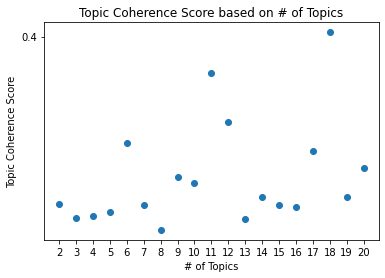

In [21]:
plt.title("Topic Coherence Score based on # of Topics")
plt.xlabel("# of Topics")
plt.ylabel("Topic Coherence Score")
plt.xticks(range(2, 21))
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.scatter(range(2, 21), coherences)
plt.show()

In [22]:
max_index = -1
max_score = -1
for index, score in enumerate(coherences):
    if score > max_score:
        max_index = index
        max_score = score
print("High Topic Coherence Score of " + str(max_score.round(4)) + " with " + str(max_index + 2) + " topics in LDA model.")

High Topic Coherence Score of 0.4012 with 18 topics in LDA model.


In [23]:
print(coherences)

[0.35358298214976613, 0.3495156672471842, 0.35017283695853085, 0.3512329051943023, 0.370303142761516, 0.35306920052231483, 0.3462456360660562, 0.3610593634096138, 0.3591734013275388, 0.3898935539123544, 0.37634624518903914, 0.34922312138736306, 0.35539284668876775, 0.3532929189888139, 0.35275361498368984, 0.36816497674728876, 0.40118614376894407, 0.3554671701438417, 0.3635920399101685]


In [37]:
lda = ldaModel(common_corpus, 18, common_dict)
pyLDAvisViz(lda, common_corpus, common_dict)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.009071  0.003039       1        1  19.229260
2     -0.021971 -0.006656       2        1  14.478502
6      0.021632  0.018027       3        1  13.368662
10    -0.008381  0.014621       4        1  11.247491
5      0.015726  0.006984       5        1   8.284387
14    -0.012285 -0.003097       6        1   7.464660
9     -0.004011  0.008694       7        1   4.716476
15     0.037955 -0.015540       8        1   4.584202
8      0.017002 -0.007879       9        1   4.108212
7     -0.000583  0.005929      10        1   3.314888
3      0.001294  0.002845      11        1   2.775681
0     -0.005360 -0.001360      12        1   2.242595
17    -0.004207  0.003677      13        1   1.317113
4      0.001388  0.010122      14        1   1.291068
1     -0.012672 -0.008229      15        1   0.999770
16    -0.016623  0.002653      16        1   0.343084
11    -0.016012 -0.002628      17        1   0.171860
12    -0.001962 -0.031202      18        1   0.062087, topic_info=         Term          Freq         Total Category  logprob  loglift
81     vaccin  21781.000000  21781.000000  Default  30.0000  30.0000
18      covid  12636.000000  12636.000000  Default  29.0000  29.0000
1570   method   4521.000000   4521.000000  Default  28.0000  28.0000
47     mandat   5468.000000   5468.000000  Default  27.0000  27.0000
3       avail   4560.000000   4560.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
108    report      1.905410   3111.204231  Topic18  -5.7757  -0.0137
55    patient      1.789038   4037.010587  Topic18  -5.8387  -0.3372
8        care      1.783977   4514.493773  Topic18  -5.8415  -0.4518
57      peopl      1.779260   4970.881788  Topic18  -5.8442  -0.5508
218     death      1.715232   2894.371762  Topic18  -5.8808  -0.0466

[1412 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
21244      1  0.095633           aarp
21244      2  0.095633           aarp
21244      3  0.191265           aarp
21244      4  0.414408           aarp
21244      5  0.031878           aarp
...      ...       ...            ...
31051      6  0.126780          yoder
31052      4  0.449898  yoderlangford
10835      2  0.677179      youcheryl
11537      8  0.664917           youi
3573       3  0.745364           ypur

[4559 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 3, 7, 11, 6, 15, 10, 16, 9, 8, 4, 1, 18, 5, 2, 17, 12, 13])